## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [12]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [13]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [14]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [15]:
total= df.user_id.nunique()
total

290584

d. The proportion of users converted.

In [16]:
df.converted.sum()/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [17]:
x1 = df[ (df.landing_page == 'new_page') & (df.group != 'treatment')]
x1.group.count()

1928

In [18]:
x2 = df[ (df.landing_page != 'new_page') & (df.group == 'treatment')]
x2.group.count()

1965

In [19]:
x1.group.count()+x2.group.count()

3893

f. Do any of the rows have missing values?

In [20]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [21]:
df2 = df.copy()
df2.drop(x1.index, inplace=True)
df2.drop(x2.index, inplace=True)
df2.shape


(290585, 5)

In [22]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [23]:
df2.user_id.nunique()

290584

In [24]:
# Double check all of the correct rows were removed - the result should be zero
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

b. There is one **user_id** repeated in **df2**.  What is it?

In [25]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [26]:
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


 d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [27]:
df2.drop_duplicates(subset=['user_id'], inplace=True)

In [28]:
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted


In [29]:
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [30]:
nRows = df2.shape[0]
df2[df2.converted == 1].converted.count()/nRows

0.11959708724499628

In [31]:
# Another way to calculate mean
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [32]:
nControl = df2.query('group=="control"').shape[0]
pControl = df2.query('converted == 1 and group =="control"').converted.count()/nControl
pControl

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [33]:
nTreatment = df2.query('group== "treatment"').shape[0]
pTreatment = df2.query('converted == 1 and group == "treatment"').converted.count()/nTreatment
pTreatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [34]:
df2.query('landing_page == "new_page"').user_id.count()/nRows

0.50006194422266881

In [35]:
df2.query('group== "treatment"').converted.count()

145310

In [36]:
df2.query('group== "control"').converted.count()

145274

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

In [37]:
obs_diff = pTreatment - pControl
obs_diff

-0.0015782389853555567


**Individuals seem to be nearly evenly split between the control and treatment groups. And, while the treatment group's conversion rate is 11.88 percent lower than the control group's conversion rate of 12.04 percent, I think the disparity is too slight, and using a new_page is not technically important.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**H_o : P_new <= P_old**


**H_a : P_new > P_old**
   

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [38]:
pNew = df2.query('converted == 1').converted.count()/df2.shape[0]
pNew

0.11959708724499628

In [39]:
# Another way to calculate mean 
pNew = df2.converted.mean()
pNew

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [40]:
# pnew and pold are equal
pOld = pNew
pOld


0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [41]:
n_new = df2.query('group =="treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [42]:
n_old = df2.query('group== "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [43]:
new_page_converted = np.random.choice([0,1], size = n_new, p=[(1-pNew), pNew])
new_page_converted

array([1, 1, 0, ..., 0, 0, 0])

In [44]:
# ANOTHER way
new_page_converted = np.random.choice(2, size = n_new, p=[(1-pNew), pNew])
new_page_converted

array([0, 0, 1, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [45]:
old_page_converted = np.random.choice(2, size = n_old, p=[(1-pOld), pOld])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [46]:
# ANOTHER way
old_page_converted = np.random.choice([0,1], size = n_old, p=[(1-pOld), pOld])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [47]:
(new_page_converted.sum() /n_new) - (old_page_converted.sum()/n_old)

0.0017253949583770217

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [48]:
df2.shape[0]

290584

In [49]:
p_diffs = []
for _ in range(10000):
    boot = df2.sample(df2.shape[0], replace=True)
    dfOld = boot.query('landing_page=="old_page"')
    dfNew = boot.query('landing_page=="new_page"')
    pOld = dfOld.query('converted ==1').shape[0]/dfOld.shape[0]
    pNew = dfNew.query('converted ==1').shape[0]/dfNew.shape[0]
    p_diffs.append(pNew-pOld)


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

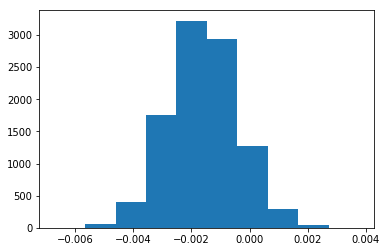

In [50]:
p_diffs= np.array(p_diffs)
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

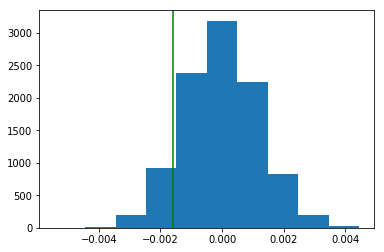

In [51]:
obs_diff = pTreatment - pControl

null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals);
plt.axvline(x=obs_diff, color='green')

In [52]:
p_val = (null_vals > obs_diff).mean()
p_val

0.89949999999999997

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**It's known as a p-value. 
Although the p-value >0.05, the null hypothesis must be rejected in favour of the alternative hypothesis with a p-value less than the form 1 error rate (alpha) false positive "FP" 5%. Since the sample didn't offer enough proof that the new website had a better conversion rate than the old page, we dismiss the null hypothesis. 
We assume that the new page has little impact based on the sample data and hypothesis testing. 
As a result, we should open the old page rather than the current one.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [53]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1').shape[0]

convert_new = df2.query('group == "treatment" & converted == 1').shape[0]

n_old = df2.query('group == "control"').shape[0]

n_new = df2.query('group == "treatment"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [54]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old],alternative = 'larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**z-score: . It calculates the distance from the mean in terms of the standardisation of the data points. For 95% CI, the normal values of critical Z-score are -1.96 and +1.96. • Although the z-score is expressed as a standard deviation of 1,3 below average, ranging from -1,96 to 1,96, the P-value is greater than 05, which is p-value =,905 p-value: The presumption that the null hypothesis is right is uncertain and is unlike the presupposition we have faisely denied it. • • Because the p-value=0,905, the chance is very high that we have wrongly dismissed the null hypothesis. • Thus, we should not dismiss this null hypothesis.
• Therefore, we should launch an older one because the current one won't do better than the old one, since the new one will not do well. The z-score and the p-value correspond in part j and k to the previous conclusions. That the zero hypothesis is not rejected**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since one meaning from two options we want to predict. And categorical data form are our answers and explanatory variables. So we are going to use regression logistics. Use for categorical details.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [55]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

In [56]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [57]:
reg_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']]).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [58]:
from scipy import stats

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
reg_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 14 Mar 2021   Pseudo R-squ.:               8.077e-06
Time:                        20:41:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**In this case, the p-value 0.19 is not unlike that observed in Part II of the 0.90180000000000005. In this respect, null and alternate assumptions are equal to or not 0.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Other variables can be considered to affect the estimation of convert. Much like they convert time and days. What is the sex? They're how old? What country do they come from? What is the quality of education? All of this knowledge helps us improve our prediction of converts. 
Adding additional explaining variables to forecast a reaction vector can be several disadvantages: 
Nonlinear interactions between the answer and the predictor
Fixed error conditions 
Unconstant variance and errors normally distributed 
High points/ Outliers 
Multichannel 
These problems could lead us to mispronouncing and we must bear that in our regression mode we add more explaining variables.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [59]:

countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [60]:

country = df_new.country.unique()
print('The countries that our users from: {}'.format(country))

The countries that our users from: ['UK' 'US' 'CA']


In [61]:

### Create the necessary dummy variables
df_new[['UK','US','CA']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [62]:
### Fit Your Linear Model And Obtain the Results

#Create interaction variable for ab_page and UK / US
df_new['ab_UK'] = df_new['ab_page'] * df_new['UK']
df_new['ab_US'] = df_new['ab_page'] * df_new['US']
reg_mod = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','UK','US']]).fit()


Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [63]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'ab_UK', 'ab_US']])

In [64]:
reg_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 14 Mar 2021   Pseudo R-squ.:               2.323e-05
Time:                        20:41:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK            -0.0408      0.027     -1.516      0.130      -0.093       0.012
US             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**The above summary indicates that p-value is above 0.05 type I defect, for countries. The means that country explanatory variable does not reject the null hypothesis for .
country and there is no statistically significant connection of our variable to the answer variable 
Consistent keeping with the other variables: 
Converted to 0.98 times as probable with any 1 unit raise in ab page. 
The probability of converting on a UK account is 0.96 times that of a CA device. 
Converted on a user from a CA user, is 1.01 times more possible. 
This initiative involves a vote on e-commerce website to open the new version, to maybe leave the old page going for a longer time to make their choice.
We discovered that the latest page wasn't different than the old one from the data review. Even if we want to check for a better country, we do not condemn the null.**

# conclusion
as a data analyst and based on my findings using the data set(ab_data.csv), The advice that I have for the concerned company is 
to maintain the old page.


# References

1- https://stackoverflow.com/questions/49814258/statsmodel-attributeerror-module-scipy-stats-has-no-attribute-chisqprob
    to solve an error saying: AttributeError: module 'scipy.stats' has no attribute 'chisqprob'.
    
2- https://medium.com/analytics-vidhya/how-to-analyze-a-b-test-results-b93c9eafbc61

3 - Udacity classroom

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [65]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0